### OutputParser 개요
OutputParser는 LLM이 생성한 자유형 텍스트/메시지를 원하는 구조(문자열, JSON, 딕셔너리, 리스트, 데이터프레임, Pydantic 모델 등)로 변환해 다운스트림 작업에 바로 쓸 수 있게 하는 컴포넌트다. 최근에는 많은 모델이 함수/툴 콜링을 지원하므로, 구조화 데이터가 주목적이라면 파서 대신 함수/툴 콜링을 우선 고려하는 것이 권장된다.


### 왜 쓰는가
- 구조화 변환: 자유 텍스트를 JSON·리스트·딕셔너리 등으로 변환해 후속 처리(검증, 저장, 분석)에 적합하게 만든다.
- 일관성 확보: 동일한 스키마와 형식을 강제해 다양한 응답을 안정적으로 처리한다.
- 스트리밍 지원: 일부 파서는 스트리밍 출력과 호환되어 실시간 처리 경험을 제공한다.

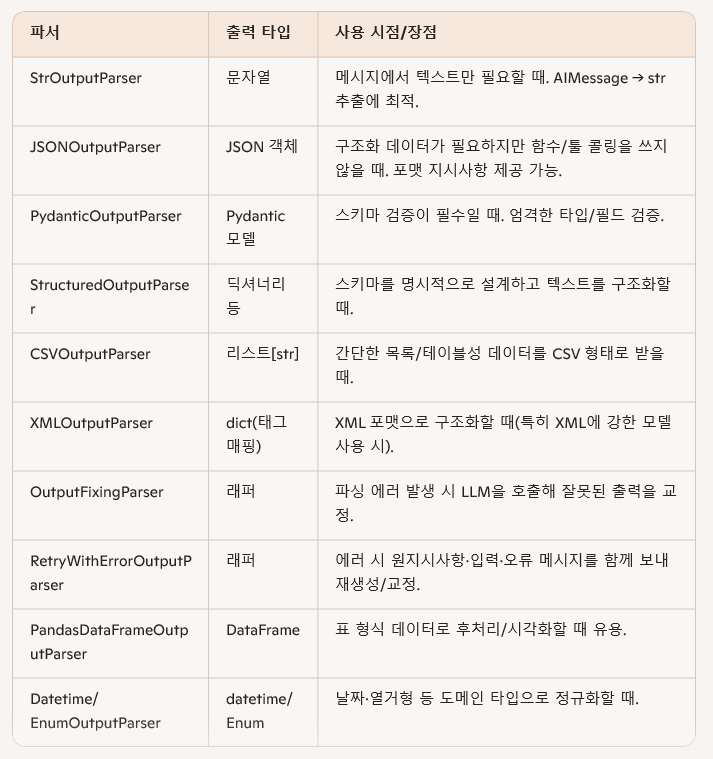

### 포맷 지시사항과 스키마
- 포맷 지시사항 제공: 대부분의 파서는 프롬프트에 “어떤 형식으로 출력하라”는 지시문을 생성/첨부할 수 있어 파싱 성공률을 높인다. 예: JSON 파서에 필드명·타입·예시를 명시해 모델이 정확히 그 스키마를 따르도록 유도한다.

- 스키마 검증: Pydantic/Structured 파서를 쓰면 모델 응답을 스키마에 맞게 검증·변환한다. 실패 시 예외를 던지거나 교정 파서로 넘겨 안정성을 높인다.

- 함수/툴 콜링 대비: 함수/툴 콜링은 모델이 스스로 스키마를 충족하는 구조화 출력을 생성하므로 파서가 불필요해질 수 있다. 구조화가 핵심이면 콜링을 우선 고려한다.

### 스트리밍과 에러 처리
- 스트리밍 지원: Str/JSON/XML/CSV 등 다수 파서가 스트리밍 입력을 지원해 토큰 단위 결과를 점진적으로 파싱할 수 있다. UI/실시간 처리에서 유리하다.

- 에러 교정 파서: OutputFixingParser와 RetryWithErrorOutputParser는 파싱 실패 시 LLM을 호출해 에러 메세지·나쁜 출력(그리고 필요 시 원지시사항)을 입력으로 주고 자동 교정을 시도한다. 포맷 일치가 자주 깨지는 환경에서 유용하다.

### 베스트 프랙티스
- 명확한 스키마: 필드명, 타입, 필수/옵션, 예시 출력을 프롬프트에 명확히 포함한다. 파서의 포맷 지시사항 생성 기능을 활용하라.

- 간단한 포맷 우선: 가능하면 단순 JSON/리스트로 시작해 성공률을 확보하고, 필요 시 Pydantic 검증을 추가한다.

- 함수/툴 콜링 고려: 구조화가 핵심 목표라면 파서보다 함수/툴 콜링을 우선 적용하고, 파서는 보조로 사용한다.

- 교정 파서 체인: 파싱 실패가 잦다면 OutputFixing/RetryWithError 래퍼를 마지막 단계에 체이닝해 복원력을 높인다.

- 스트리밍 시 주의: 스트리밍 파싱은 부분 출력이 불완전할 수 있으므로 버퍼링·종료 조건을 관리해 최종 일관성을 확보한다.


### 파서 선택 가이드
- 텍스트만 필요: StrOutputParser.
- 간단한 구조화 데이터: JSONOutputParser 또는 StructuredOutputParser.
- 엄격한 검증/타입 필요: PydanticOutputParser.
- 출력 안정화 필요: OutputFixingParser / RetryWithErrorOutputParser 래핑.
- 대화/메시지 컨텐츠 정규화: Str 파서로 메시지 콘텐츠 블록에서 텍스트 추출.
- 최신 모델·도구 사용: 함수/툴 콜링 우선, 파서는 보조 수단으로.





In [1]:
from dotenv import load_dotenv
import os
# .env 파일을 불러와서 환경 변수로 설정
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:10])

gsk_yyCaCf


#### 1. CommaSeparatedListOutputParser


In [2]:
from langchain_core.output_parsers import CommaSeparatedListOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
import csv

# 콤마로 구분된 리스트 출력 파서 초기화
output_parser = CommaSeparatedListOutputParser()

# 출력 형식 지침 가져오기
format_instructions = output_parser.get_format_instructions()
print(format_instructions)

Your response should be a list of comma separated values, eg: `foo, bar, baz` or `foo,bar,baz`


In [3]:

# 프롬프트 템플릿 설정
prompt = PromptTemplate(
    template="List five {subject}.\n{format_instructions}",
    input_variables=["subject"],
    partial_variables={"format_instructions": format_instructions},
)

# OpenAI 모델 설정
#model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
llm = ChatOpenAI(
    base_url="https://api.groq.com/openai/v1",  # Groq API 엔드포인트
    #model="meta-llama/llama-4-scout-17b-16e-instruct",  # Spring AI와 동일한 모델
    model="moonshotai/kimi-k2-instruct-0905",
    #model="openai/gpt-oss-120b",
    temperature=0.7
)

In [4]:
chain = prompt | llm | output_parser

result = chain.invoke({"subject": "2025년 웹 기술"})

print("2025년 웹 기술 목록")
print(result)

# csv 파일로 저장
csv_filename = "../data/web_tech.csv"
with open(csv_filename, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["웹 기술"]) # header

    for item in result:
        writer.writerow([item])


print(f" '{csv_filename}' 파일로 저장 완료!")


2025년 웹 기술 목록
['WebAssembly (WASM) 3.0', 'AI-Native Component Architecture', 'Edge-Native Frameworks', 'Federated Learning Platforms', 'Quantum-Safe Cryptography']
 '../data/web_tech.csv' 파일로 저장 완료!


#### 2. JsonOutputParser

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
import json

# JSON 출력 파서 초기화
parser = JsonOutputParser()

prompt = ChatPromptTemplate.from_messages(
    [
       ("system", "너는 수학 분야 전문가 AI야. 질문에 대해 체계적이고 간결한 답변을 JSON 형식으로 제공해줘줘."),
       ("user", "#Format: {format_instructions}\n\n#Question: {question}"),        
    ]
)

# JSON 출력 형식 지침을 프롬프트에 적용
prompt = prompt.partial(format_instructions=parser.get_format_instructions())
# PromptTemplate 또는 ChatPromptTemplate 에 정의된 변수 중 일부를 미리 고정값으로 채워 넣는 메서드
# 즉, 부분 적용(partial application) 을 통해 템플릿을 더 간단하게 만들어줌
# 나머지 변수는 실행 시점에 여전히 입력으로 받을 수 있음
# get_format_instructions함수는 LLM에게 “출력을 어떤 형식으로 내야 하는지” 알려주는 지시문(string) 을 생성해줌


chain = prompt | llm | parser

# 질문 설정 (우주 탐사 관련 질문)
question = "올해 수학계에서 뜨거운 감자인 주제에 대해 3가지 알려줘. \
각 주제의 이름은 `mission_name`에, 목표는 `goal`에, 주관 기관은 `agency`에 담아 줘."

# 체인 실행 및 JSON 응답 받기
response = chain.invoke({"question": question})

# JSON 데이터 출력
print(json.dumps(response, indent=4, ensure_ascii=False))


[
    {
        "mission_name": "김-스탁 파라미터 추측 해결",
        "goal": "정수론과 대수기하학의 경계에 있는 김-스탁 추측의 완전한 증명",
        "agency": "MIT 하버드 협동 연구팀"
    },
    {
        "mission_name": "4차원 Poincaré 추측 일반화",
        "goal": "초대칭 구조를 포함한 4차원 다양체의 완전 분류",
        "agency": "Clay Mathematics Institute"
    },
    {
        "mission_name": "AI 기반 수학 증명 시스템",
        "goal": "인공지능이 독자적으로 새로운 정리를 창출하고 증명하는 플랫폼 구축",
        "agency": "DeepMind-Microsoft Research 공동 프로젝트"
    }
]


#### CommaSeparatedListOutputParser

In [6]:
from langchain_core.output_parsers import CommaSeparatedListOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
import csv

# 콤마로 구분된 리스트 출력 파서 초기화
output_parser = CommaSeparatedListOutputParser()

# 출력 형식 지침 가져오기
format_instructions = output_parser.get_format_instructions()
print(format_instructions)

Your response should be a list of comma separated values, eg: `foo, bar, baz` or `foo,bar,baz`


In [7]:

# 프롬프트 템플릿 설정
prompt = PromptTemplate(
    template="List five {subject}.\n{format_instructions}",
    input_variables=["subject"],
    partial_variables={"format_instructions": format_instructions},
)

# OpenAI 모델 설정
#model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
llm = ChatOpenAI(
    base_url="https://api.groq.com/openai/v1",  # Groq API 엔드포인트
    #model="meta-llama/llama-4-scout-17b-16e-instruct",  # Spring AI와 동일한 모델
    model="moonshotai/kimi-k2-instruct-0905",
    #model="openai/gpt-oss-120b",
    temperature=0.7
)

In [8]:
# 프롬프트, 모델, 출력 파서를 연결하여 체인 생성
chain = prompt | llm | output_parser

# "AI 관련 기술"에 대한 체인 호출 실행
result = chain.invoke({"subject": "AI 관련 기술"})

# 쉼표로 구분된 리스트 출력
print("AI 관련 기술 목록:")
print(result)

# 결과 활용 예시: CSV 파일로 저장
csv_filename = "../data/ai_technologies.csv"
with open(csv_filename, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["AI 기술"])  # 헤더 추가
    for item in result:
        writer.writerow([item])

print(f" '{csv_filename}' 파일로 저장 완료!")

AI 관련 기술 목록:
['`Machine Learning', 'Deep Learning', 'Natural Language Processing', 'Computer Vision', 'Reinforcement Learning`']
 '../data/ai_technologies.csv' 파일로 저장 완료!


#### JsonOutputParser

In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
import json

# JSON 출력 파서 초기화
parser = JsonOutputParser()

# 프롬프트 템플릿을 설정합니다.
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "당신은 과학 분야 전문가 AI입니다. 질문에 대해 체계적이고 간결한 답변을 JSON 형식으로 제공하세요."),
        ("user", "#Format: {format_instructions}\n\n#Question: {question}"),
    ]
)

# JSON 출력 형식 지침을 프롬프트에 적용
prompt = prompt.partial(format_instructions=parser.get_format_instructions())

# OpenAI 모델 설정
#llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# 프롬프트, 모델, 출력 파서를 연결하는 체인 생성
chain = prompt | llm | parser

# 질문 설정 (우주 탐사 관련 질문)
question = "최근 10년간 진행된 주요 우주 탐사 미션 3가지를 알려주세요. \
각 미션의 이름은 `mission_name`에, 목표는 `goal`에, 주관 기관은 `agency`에 담아 주세요."

# 체인 실행 및 JSON 응답 받기
response = chain.invoke({"question": question})

# JSON 데이터 출력
print(json.dumps(response, indent=4, ensure_ascii=False))


[
    {
        "mission_name": "Perseverance (Mars 2020)",
        "goal": "화성의 고대 생명 흔명 탐색, 샘플 캐싱 및 현장 분석",
        "agency": "NASA"
    },
    {
        "mission_name": "JUICE",
        "goal": "목성 및 가니메데·칼리스토·유로파 등 위성들의 대기·표면·내부 구조 연구",
        "agency": "ESA"
    },
    {
        "mission_name": "Chang’e 4",
        "goal": "인류 최초 달 뒷면 착륙, 지하 구조 및 저중력 환경 탐사",
        "agency": "CNSA"
    }
]


#### PandasDataFrameOutputParser

In [10]:
import pandas as pd
from langchain.output_parsers import PandasDataFrameOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
import re

# Titanic 데이터셋 로드
df = pd.read_csv('../data/titanic.csv')

# Pandas DataFrame Output Parser 설정
parser = PandasDataFrameOutputParser(dataframe=df)

# 형식 지침 출력
format_instructions = parser.get_format_instructions()
print("Format Instructions:\n", format_instructions)

# 프롬프트 템플릿 설정
prompt = PromptTemplate(
    template=""" 
    You are a helpful assistant that interacts with a Pandas DataFrame.
    The DataFrame contains the following columns: {columns}.
    
    Your task is to answer the user's query by generating a command in the following format:
    {format_instructions}
    
    User Query: {query}    
    """,
    input_variables=["query"], # 실행 시 반드시 채워져야 하는 변수 목록록
    partial_variables={ # 미리 고정해둔 변수 (항상 같은 값/함수수 결과로 채워짐)
        "format_instructions": format_instructions,
        "columns": ", ".join(df.columns)
    },
)

# 체인 생성
chain = prompt | llm | parser

# 모델 응답 받기
try:
    # **Name 열을 표시하십시오.**
    print('Name 컬럼 출력')
    df_query = "Show the Name column"

    parser_output = chain.invoke({"query": df_query})
    print(type(parser_output))
    print(parser_output)

    # **첫번째 행을 표시하십시오.**
    print('첫번째 행 출력')
    df_query2 = "Show first row"

    parser_output2 = chain.invoke({"query": df_query2})
    print(parser_output2)

    #Please tell me the average value of the Fare column.
    print('Farre 컬럼의 평균값 출력')
    df_query3 = "Show me the average value of the Fare column."

    parser_output3 = chain.invoke({"query": df_query3})
    print(parser_output3)

except Exception as e:
    print(f"오류 발생: {e}")


Format Instructions:
 The output should be formatted as a string as the operation, followed by a colon, followed by the column or row to be queried on, followed by optional array parameters.
1. The column names are limited to the possible columns below.
2. Arrays must either be a comma-separated list of numbers formatted as [1,3,5], or it must be in range of numbers formatted as [0..4].
3. Remember that arrays are optional and not necessarily required.
4. If the column is not in the possible columns or the operation is not a valid Pandas DataFrame operation, return why it is invalid as a sentence starting with either "Invalid column" or "Invalid operation".

As an example, for the formats:
1. String "column:num_legs" is a well-formatted instance which gets the column num_legs, where num_legs is a possible column.
2. String "row:1" is a well-formatted instance which gets row 1.
3. String "column:num_legs[1,2]" is a well-formatted instance which gets the column num_legs for rows 1 and 2,

In [11]:
import pandas as pd
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

# OpenAI 모델 초기화
#llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
llm = ChatOpenAI(
    api_key=OPENAI_API_KEY,
    base_url="https://api.groq.com/openai/v1",  # Groq API 엔드포인트
    #model="meta-llama/llama-4-scout-17b-16e-instruct",
    model="moonshotai/kimi-k2-instruct-0905",
    temperature=0
)

# 응답 스키마 정의 [{},{},{}]
response_schemas = [
    #ResponseSchema(name="data", description="A list of dictionaries representing table rows."),
    ResponseSchema(name="data", description="테이블 행을 나타내는 딕셔너리들의 리스트"),
]

# Output Parser 설정
parser = StructuredOutputParser.from_response_schemas(response_schemas)

# 프롬프트 템플릿 설정
prompt = PromptTemplate(
    template="""
    당신은 테이블 형태의 데이터를 생성하는 AI 어시스턴트입니다(You are an AI assistant that generates tabular data).
    반드시 다음 스키마를 따르는 JSON 형식으로 데이터를 반환해야 합니다(You must return the data in JSON format that follows this schema):

    {format_instructions}
        
    **User Query:**
    {query}
    """,
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# 체인 생성 (프롬프트 → 모델 → StructuredOutputParser)
chain = prompt | llm | parser

# 실행 함수
def generate_dataframe(user_query):
    try:
        # 모델 호출
        json_response = chain.invoke({"query": user_query})

        # 모델이 반환한 JSON을 Pandas DataFrame으로 변환
        df = pd.DataFrame(json_response["data"])

        # 결과 출력
        print("\n Generated DataFrame:\n")
        return df

    except Exception as e:
        print(f" 오류 발생: {e}")
        return None

In [12]:
# [예제 1] 2024년 상반기 서울 아파트 평균 매매 가격 데이터 생성
print('2024년 상반기 서울 아파트 평균 매매 가격 데이터 생성')
df_seoul_housing = generate_dataframe(
    #"Create a dataset of the average apartment sale prices in Seoul for the first half of 2024 with columns: District (구), Average Price (in KRW), Number of Transactions, and Year-over-Year Change (%)."
    "2024년 상반기 서울 아파트 평균 매매가격 데이터셋을 생성해주세요. 컬럼은 다음과 같습니다: 구(District), 평균가격_억원(Average_Price_100M_KRW), 거래건수(Transactions), 전년동기대비증감률_퍼센트(YoY_Change_Percent). 서울의 25개 구에 대한 현실적인 데이터를 생성해주세요."
)
df_seoul_housing.head()


2024년 상반기 서울 아파트 평균 매매 가격 데이터 생성

 Generated DataFrame:



,District,Average_Price_100M_KRW,Transactions,YoY_Change_Percent
0,강남구,12.3,1850,-2.1
1,강동구,7.8,1320,1.5
2,강북구,5.2,890,0.8
3,강서구,6.4,1150,2.3
4,관악구,5.7,980,1.2


In [13]:
print('2024년 서울 지하철역별 유동 인구 데이터')
# [예제 2] 2024년 서울 지하철역별 유동 인구 데이터
df_seoul_subway = generate_dataframe(
    #"Generate a dataset of the top 10 busiest subway stations in Seoul in 2024 with columns: Station Name, Line Number, Daily Passenger Volume, and Weekday vs Weekend Ratio."
    "2024년 서울 지하철 승객 이용량이 가장 많은 상위 10개 역의 데이터셋을 생성해주세요. 컬럼은 다음과 같습니다: 역명(Station_Name), 호선(Line_Number), 일평균승객수_만명(Daily_Passengers_10K), 평일대주말비율(Weekday_Weekend_Ratio). 실제 서울 지하철의 주요 역들을 기반으로 현실적인 데이터를 생성해주세요."
)

#if df_seoul_subway is not None:
df_seoul_subway.head()

2024년 서울 지하철역별 유동 인구 데이터

 Generated DataFrame:



,Station_Name,Line_Number,Daily_Passengers_10K,Weekday_Weekend_Ratio
0,강남,2호선,19.8,1.42
1,서울,1호선,18.3,1.38
2,신도림,2호선,17.5,1.35
3,홍대입구,2호선,16.9,1.28
4,고속터미널,3호선,16.2,1.30
